**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from scipy import optimize
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import time 

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We insert that $\tilde{w} = (1-\tau)w$ in the constraint and substitute the constraint into the maximization problem and solve the problem analytically by finding the FOC:
$$
\max_{L\in[0,24]}\ln\left((\kappa + \tilde{w}L))^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2} 
$$

FOC:

$$
\frac{\alpha (\kappa + \tilde{w}L)^{\alpha-1} \tilde{w}G^{1-\alpha}}{(\kappa + \tilde{w}L)^{\alpha-1}G^{1-\alpha}} - \nu L = 0 \Leftrightarrow
$$

$$
\alpha (\kappa + \tilde{w}L)^{-1} \tilde{w} - \nu L = 0 \Leftrightarrow
$$

$$
- \tilde{w} L^2 - \kappa L + \frac{\alpha \tilde{w}}{\nu} = 0
$$

This is a 2. degree polynomium and we recognise the solution as: 

$$
\frac{-b +- \sqrt{b^2 - 4ac}}{2a}
$$

Looking at the coefficients this is the same as $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$ so it is confirmed analytically. 

In [2]:
# set baseline parameters
kappa = 1.0
nu = 1 / (2 * 16 ** 2)
w = 1.0
tau = 0.30
w_tilde = (1 - tau) * w
alpha = 0.5 

In [3]:
# ANALYTICAL SOLUTION

# calculate L* using the analytical solution
L_star = (-kappa + np.sqrt(kappa ** 2 + 4 * (alpha / nu) * ((1 - tau) * w) ** 2)) / (2 * ((1 - tau) * w))
print("Optimal L analytically:", L_star)
print("")

# NUMERICAL SOLUTION

# Define the objective function
def w_util(L, G):
    w_util = (np.log((kappa + ((1 - tau) * w) * L) ** alpha * G ** (1 - alpha)) - nu * L ** 2 / 2)
    return -w_util

def solve_opt_L(G):

    # Call the optimizer
    result = optimize.minimize(w_util, x0=12, args=(G,), method='SLSQP', bounds=[(1e-8, 24)], tol=1e-10)
    return result.x[0]

# Solve for G = 1
optimal_L_G1 = solve_opt_L(1)
print("Optimal L for G = 1:", optimal_L_G1)
print("")

# Solve for G = 2
optimal_L_G2 = solve_opt_L(2)
print("Optimal L for G = 2:", optimal_L_G2)


Optimal L analytically: 15.30165022719559

Optimal L for G = 1: 15.301629699811963

Optimal L for G = 2: 15.301624822738493


We see from this that there is a small difference due to numerical precision issues, but in total the analytical solution is confirmed numerically. 

****

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

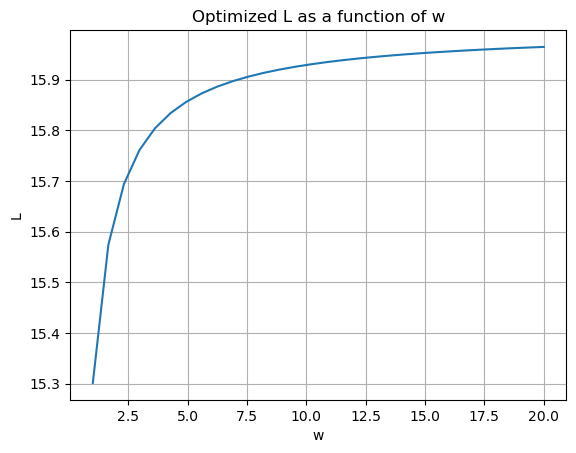

In [4]:
# setting a grid for w and an empty array for the solutions. 
w_values = np.linspace(1, 20, 30)
L_solutions = []

# Looping over the different values in the w_values array.
for w in w_values:
    L = solve_opt_L(1)  # G = 1 but it doesn't matter what we set G to
    L_solutions.append(L)

# plotting the results 
plt.plot(w_values, L_solutions)
plt.xlabel('w')
plt.ylabel('L')
plt.title('Optimized L as a function of w')
plt.grid(True)
plt.show()

# We set back the value of w to 1 because otherwise it has the last value of the loop going forward
w = 1


This shows that when the after-tax wage increases, the optimal amount of work also increases but this effect is diminishing.

*****


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


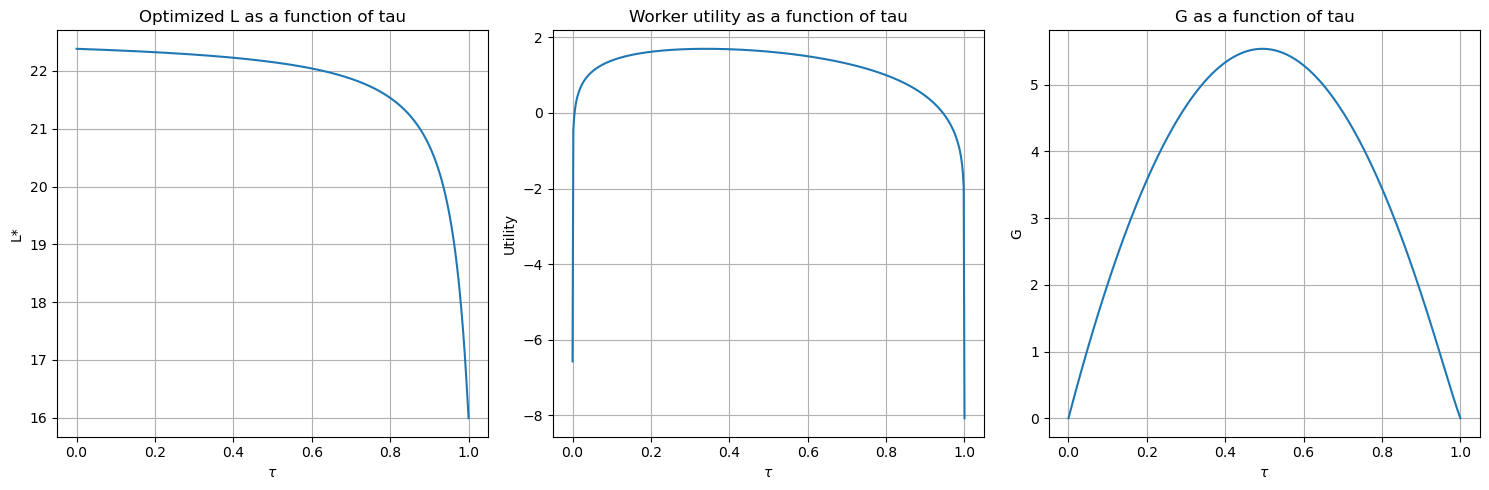

In [5]:
# Setting a grid for tau
Grid = 500

# tau can be between 0 and 1
tau_values = np.linspace(1e-8, 1-1e-8, Grid)

# setting emty arrays for the solutions
L_solutions = np.empty(Grid)
obj_values = np.empty(Grid)
G_values = np.empty(Grid)

for i,tau in enumerate(tau_values):
    
    # In this utility function we insert the expression for G that is given in the assignment
    def obj(L,tau):
        
        G = tau*w*L*((1-tau)*w)

        obj_value =  - (np.log((kappa + (1 - tau) * w * L) ** alpha * G ** (1 - alpha)) - nu * L ** 2 / 2)
        
        return obj_value

    # Call the optimizer
    result = optimize.minimize(obj, x0=12,
                                method='SLSQP',
                                bounds=[(1e-8, 24)], # the worker can work between 0 and 24 hours
                                args=tau)  # Pass tau as additional argument
    
    # Retrieve the optimized value of L
    L_solutions[i] = result.x

    # Use this optimized value of L to find the value of the utility function
    obj_values[i] = -obj(result.x, tau)

    # Using the optimal value of L to find the government purchases
    G_values[i] = tau * w * result.x * ((1 - tau) * w)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Data list
plot_data = [(L_solutions, 'L*', 'Optimized L as a function of tau'),
             (obj_values, 'Utility', 'Worker utility as a function of tau'),
             (G_values, 'G', 'G as a function of tau')]

# Loop over plot_data
for i, (data, ylabel, title) in enumerate(plot_data):
    axs[i].plot(tau_values, data)
    axs[i].set_xlabel('$\\tau$')
    axs[i].set_ylabel(ylabel)
    axs[i].set_title(title)
    axs[i].grid(True)

# Show plots
plt.tight_layout()
plt.show()

This shows that: 1) when the tax increases, labor hours decline, 2) initially, higher tax will increase utility, but after a certain point it declines again, 3) The government's tax revenue is a Laffer curve.

****

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

Using the optimization above where we looked at a grid of possible values for tau, we can find the highest utility function and then find the corresponding value of tau.

In [6]:
# We find the maximum value of the utility function from the grid optimization above.
# Then we find the corresponding vlaue of the tax.
tau = float(tau_values[np.where(obj_values == max(obj_values))[0]])
print("The socially optimal value of tau is: ",(tau))

The socially optimal value of tau is:  0.3406813659118236


This shows that the socially optimal level of tax is approx. 34 pct. 

****

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [7]:
# Parameters for question 5
sigma = 1.001
rho = 1.001
epsilon = 1


def fun(sigma= 1.001, rho= 1.001, tau=tau, option=False):

    # Define the objective function (the new utility funciton for the worker)
    def obj(L, G):
        C = kappa + (1 - tau) * w * L
        term1 = alpha * C ** ((sigma - 1) / sigma)
        term2 = (1 - alpha) * G ** ((sigma - 1) / sigma)
        numerator = (term1 + term2) ** (sigma / (sigma-1))
        denominator = 1 - rho
        expression = ((numerator ** (1 - rho)) - 1) / denominator - nu * (L ** (1 + epsilon)) / (1 + epsilon)
        return -expression

    # Solve the worker problem for a given value of G
    def L(G):
        result = optimize.minimize(obj, x0=12, method='SLSQP', bounds=[(1e-8, 24)], args=G)
        return result.x[0]

    # The budget constraint for the government
    def eq_constraint(G):
        L_star = L(G)  # Use L() function to get the optimal value of L for a given G
        return G - tau * w * L_star  # violated if negative

    def maximize_G():

        # Call the optimizer
        result = optimize.root(eq_constraint, x0=10, method='hybr', tol=1e-10)

        # Retrieve the optimal value of G
        optimal_G = result.x[0]

        return optimal_G

    optimal_G = maximize_G()

    # Calculate the corresponding optimal value of L
    optimal_L = L(optimal_G)

    # Calculate the optimal utility
    optimal_utility = -obj(optimal_L, optimal_G)


    if option:
        return optimal_utility
    else:
        return optimal_G, optimal_L

optimal_G, optimal_L = fun(sigma = 1.001,rho = 1.001)
print("Optimal G with sigma = 1.001,rho = 1.001:", optimal_G)
print("Optimal L with sigma = 1.001,rho = 1.001:", optimal_L)

print("")

optimal_G, optimal_L = fun(sigma = 1.5,rho = 1.5)
print("Optimal G with sigma = 1.5,rho = 1.5:", optimal_G)
print("Optimal L with sigma = 1.5,rho = 1.5:", optimal_L)


Optimal G with sigma = 1.001,rho = 1.001: 5.192522224207778
Optimal L with sigma = 1.001,rho = 1.001: 15.241509673994363

Optimal G with sigma = 1.5,rho = 1.5: 3.5504100661501576
Optimal L with sigma = 1.5,rho = 1.5: 10.421497771364415


When we set $\sigma=\rho=1$ in the utility function above we ge the Cobb Douglas utility function. Setting them to almost 1 (1.001) is a borderline case that gives radical results, as will be clear in the plot below. 

****

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

We are finding the optimal tax, $\tau^*$, by applying a grid search for different values of $\tau$. We are using the same function as above to optimize utility, while not violating the governments budget constraint for different values of $\tau$.

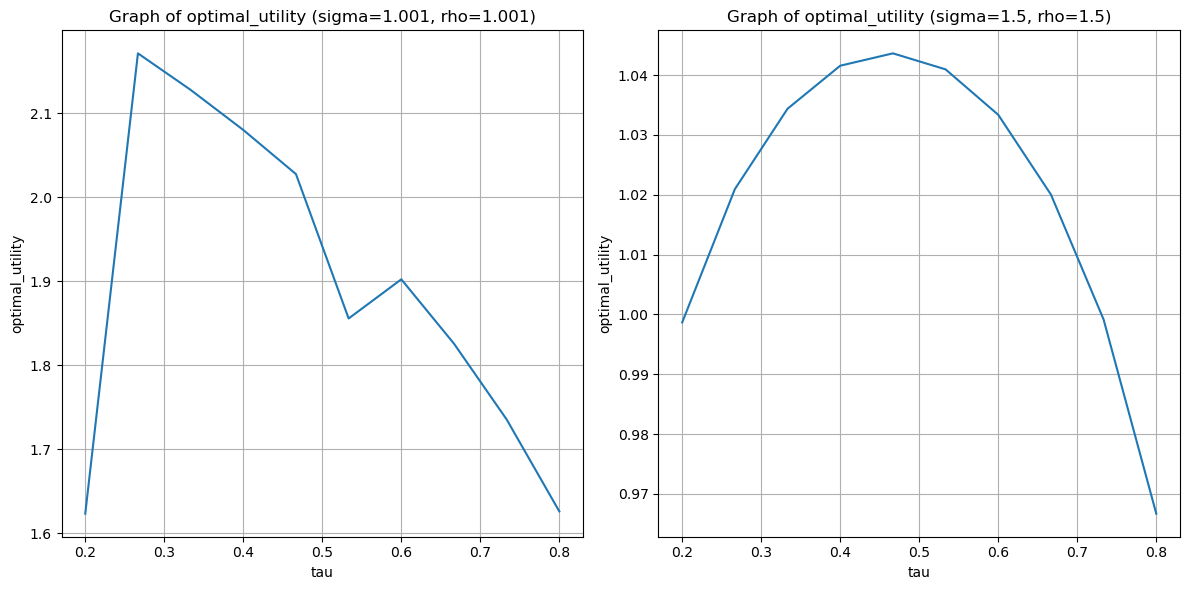

When sigma=rho=1.001 the optimal tau is:  [0.26666667]
When sigma=rho=1.5 the optimal tau is:  [0.46666667]


In [8]:
# Define the range of tau values
tau_values = np.linspace(0.2, 0.8, 10)

# Initialize empty lists to store the optimal utilities for each sigma value
optimal_utilities_sigma_rho_1_001 = []
optimal_utilities_sigma_rho_1_5 = []

# Iterate over each tau value and calculate the corresponding optimal utilities for sigma=1.001
for tau in tau_values:
    optimal_utility = fun(sigma=1.001, rho=1.001, tau=tau, option=True)
    optimal_utilities_sigma_rho_1_001.append(optimal_utility)

# Iterate over each tau value and calculate the corresponding optimal utilities for sigma=1.5
for tau in tau_values:
    optimal_utility = fun(sigma=1.5, rho=1.5, tau=tau, option=True)
    optimal_utilities_sigma_rho_1_5.append(optimal_utility)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for sigma=1.001
ax1.plot(tau_values, optimal_utilities_sigma_rho_1_001)
ax1.set_xlabel('tau')
ax1.set_ylabel('optimal_utility')
ax1.set_title('Graph of optimal_utility (sigma=1.001, rho=1.001)')
ax1.grid(True)

# Plot for sigma=1.5
ax2.plot(tau_values, optimal_utilities_sigma_rho_1_5)
ax2.set_xlabel('tau')
ax2.set_ylabel('optimal_utility')
ax2.set_title('Graph of optimal_utility (sigma=1.5, rho=1.5)')
ax2.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

print("When sigma=rho=1.001 the optimal tau is: ",(tau_values[np.where(optimal_utilities_sigma_rho_1_001 == max(optimal_utilities_sigma_rho_1_001))[0]]))
print("When sigma=rho=1.5 the optimal tau is: ",(tau_values[np.where(optimal_utilities_sigma_rho_1_5 == max(optimal_utilities_sigma_rho_1_5))[0]]))

We are plotting utility as a function of tau, to visualize the results. We see that setting $\sigma=\rho=1.001$ constitutes a borderline case for which the utility function behaves very strange for different values of $\tau$. When setting $\sigma=\rho=1.5$ we get a nice continuoes function of $\tau$.

In the case $\sigma=\rho=1.001$ we find that the optimal tax rate is approx. 27 pct.
In the case $\sigma=\rho=1.5$ we find that the optimal tax rate is approx. 47 pct.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [9]:
# set parameters
eta = 0.5
w = 1.0

# Define the analytical solution
def l_star(kappa):
    return ((1-eta)*kappa/w) ** (1/eta)

# Define the range of kappa values
kappa_values = np.linspace(1, 2, 2)

# Initialize empty lists to store the optimal utilities for each sigma value
l_solutions = np.empty(2)

for i,kappa in enumerate(kappa_values):
    # Define the objective function
    
    # In this utility function we insert the expression for omega_tilde back into the utility function
    def obj(l,kappa):
        profit = (kappa * l ** (1-eta) - w * l)
        return -profit

    result = optimize.minimize(obj, x0=1/2, bounds = [(0.0001,None)], args=kappa)  # Pass kappa as additional argument
    
    # Retrieve the optimized value of L
    l_solutions[i] = result.x

print("The optimal l_t found by analytical maximization with kappa=1 is", l_star(1))
print("")
print("The optimal l_t found by analytical maximization with kappa=2 is", l_star(2))
print("")
print("The optimal l_t found by numerical maximization with kappa=1 is", l_solutions[0])
print("")
print("The optimal l_t found by numerical maximization with kappa=2 is", l_solutions[1])

The optimal l_t found by analytical maximization with kappa=1 is 0.25

The optimal l_t found by analytical maximization with kappa=2 is 1.0

The optimal l_t found by numerical maximization with kappa=1 is 0.2500044022504854

The optimal l_t found by numerical maximization with kappa=2 is 0.9999998836242338


Hence, it is confirmed because the numerical optimization gives the same values for the optimal $\ell$ as the analytical solution gives.

****

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [10]:
# Setting a value of seed used throughout the assignment
seed_1 = 2000
np.random.seed(seed_1)

# Parameters
K = 100
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01)**(1/12)
T = 119 # setting the number of periods to 119

# Function to calculate h for a given shock series
def h_function(shock_series):
    t = len(shock_series)  # Number of time periods
    epsilon_t = np.concatenate(([0], shock_series))  # Add initial shock value of 0
    kappa_t = np.zeros(t+1)  # Array to store values of kappa_t
    l_t = np.zeros(t+1)  # Array to store values of l_t
    
    kappa_t[0] = 1  # Initial value for kappa_t
    l_t[0] = 0  # Initial value for l_t
    
    for i in range(t):
        kappa_t[i+1] = np.exp(rho * np.log(kappa_t[i]) + epsilon_t[i])  # AR(1) process for kappa_t
        l_t[i+1] = ((1 - eta) * kappa_t[i+1] / w) ** (1 / eta)  # Optimal l_t based on the given policy
    
    indicator = np.concatenate(([0], (l_t[1:] != l_t[:-1]).astype(float)))  # Indicator function for l_t != l_t-1
    indicator = indicator * iota  # Indicator function for adjustment costs
    
    profits = kappa_t[1:t+1] * l_t[1:t+1]**(1 - eta) - w * l_t[1:t+1] - indicator[:t]  # Profits

    discounted_profits = np.sum(R**-np.arange(t) * profits)  # Discounted profits
    return discounted_profits

# Function to calculate H based on Monte Carlo simulation
def calculate_H(K):
    shock_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(K, T))  # Generate shock series with T periods for every K. 
    h_values = np.apply_along_axis(h_function, axis=1, arr=shock_series)  # Calculate h for each shock series
    H = 1/K*np.sum(h_values)  # Approximate H as the average of h values
    return H

H = calculate_H(K)
print("Using the optimal amount of labor given in the assignement, we find that the max of H is:", H)

Using the optimal amount of labor given in the assignement, we find that the max of H is: 27.12110624229763


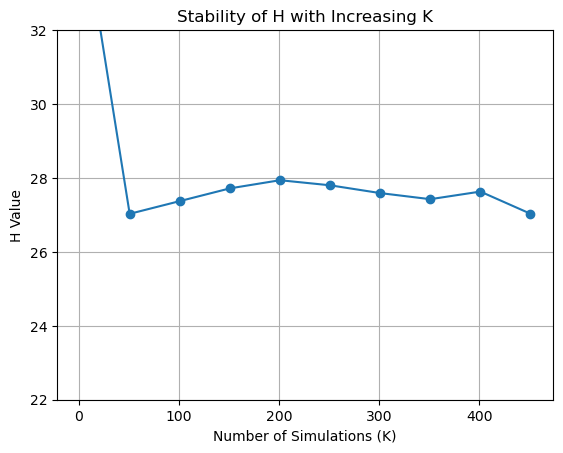

In [11]:
np.random.seed(seed_1)

# Perform simulations with increasing values of K
K_values = list(range(1, 501, 50))
H_values = []

for K in K_values:
    H = calculate_H(K)
    H_values.append(H)

# Plot the results
plt.plot(K_values, H_values, marker='o')
plt.xlabel('Number of Simulations (K)')
plt.ylabel('H Value')
plt.ylim(22,32)
plt.title('Stability of H with Increasing K')
plt.grid(True)
plt.show()

# Setting K back to 100 otherwise it is 451 going forward
K = 100

From the plot above we see that the stability of the solutions to H does not increase significantly when we set K above 100.

****

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [12]:
np.random.seed(seed_1)

def h_function_Delta(shock_series, Delta):
    t = len(shock_series)  # Number of time periods
    epsilon_t = np.concatenate(([0], shock_series))  # Add initial shock value of 0
    kappa_t = np.zeros(t+1)  # Array to store values of kappa_t
    l_t = np.zeros(t+1)  # Array to store values of l_t
    
    kappa_t[0] = 1  # Initial value for kappa_t
    l_t[0] = 0  # Initial value for l_t
    
    # Defining the decision rule for when to adjust labor
    for i in range(t):
        kappa_t[i+1] = np.exp(rho * np.log(kappa_t[i]) + epsilon_t[i])  # AR(1) process for kappa_t
        # The cristeria for when to adjust labor is the following:
        if i == 0 or np.abs(l_t[i] - ((1 - eta) * kappa_t[i+1] / w) ** (1 / eta)) > Delta:
            l_t[i+1] = ((1 - eta) * kappa_t[i+1] / w) ** (1 / eta)  # Optimal l_t based on the given policy
        else:
            l_t[i+1] = l_t[i]

    indicator = np.concatenate(([0], (l_t[1:] != l_t[:-1]).astype(float)))  # Indicator function for labor differs from last period
    indicator = indicator * iota  # Indicator function for adjustment costs
    
    profits = kappa_t[1:t+1] * l_t[1:t+1]**(1 - eta) - w * l_t[1:t+1] - indicator[:t] 

    discounted_profits = np.sum(R**-np.arange(t) * profits)  
    
    return discounted_profits

# Function to calculate H 
def calculate_H_Delta(K, Delta):
    # Defining the shock series
    shock_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(K, T))
    # Calculating h for each shock series
    h_values = np.apply_along_axis(h_function_Delta, axis=1, arr=shock_series, Delta=Delta)
    # Approximate H as the average of h values
    H = 1/K * np.sum(h_values)
    return H

H = calculate_H_Delta(K, Delta=0.05)
print("Implementing the new ploicy we find that the max of H is:", H)

Implementing the new ploicy we find that the max of H is: 27.792457965183623


This shows that the change does improve profitbility, but by very little.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

The maximum value of H is:  29.17443395010169
The optimal value of Delta is:  0.08615384615384615


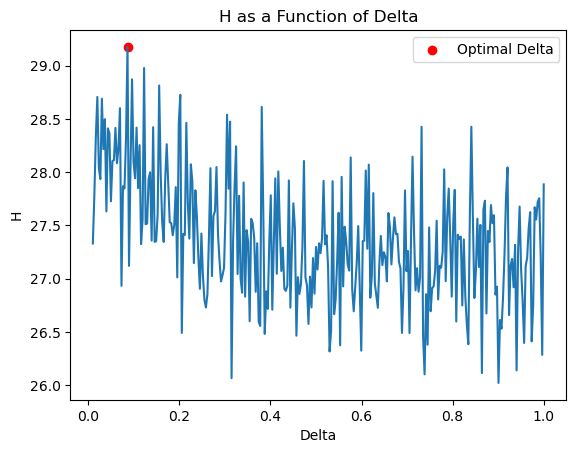

In [13]:
np.random.seed(seed_1)

delta_values = np.linspace(0.01, 1, 300)  # Range of Delta values to consider
H_values = []  # List to store the H values

# Finding H values for different values of Delta
for delta in delta_values:
    H = calculate_H_Delta(K, Delta=delta)
    H_values.append(H)

# Looking in the arrays to find the optimal value of Delta
max_H = max(H_values)
optimal_delta = delta_values[H_values.index(max_H)]

print('The maximum value of H is: ', max_H)
print('The optimal value of Delta is: ', optimal_delta)

# Plotting
plt.plot(delta_values, H_values)
plt.xlabel('Delta')
plt.ylabel('H')
plt.title('H as a Function of Delta')
plt.scatter(optimal_delta, max_H, color='red', label='Optimal Delta')
plt.legend()
plt.show()

This shows that H varies a lot due to demand shocks but the level is lower for Delta greater than approx. 0.4.

****


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



The new policy we implement is such that we look at the average of the last 5 periods instead of just looking at the last period. The new rule looks like:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\frac{1}{5} \sum_{i=1}^5 \ell_{t-i}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.

In [14]:
np.random.seed(seed_1)

def h_function_Delta_hoarding(shock_series, Delta):
    t = len(shock_series)  # Number of time periods
    epsilon_t = np.concatenate(([0], shock_series))  # Add initial shock value of 0
    kappa_t = np.zeros(t+1)  # Array to store values of kappa_t
    l_t = np.zeros(t+1)  # Array to store values of l_t
    
    kappa_t[0] = 1  # Initial value for kappa_t
    l_t[0] = 0  # Initial value for l_t
    
    for i in range(t):
        kappa_t[i+1] = np.exp(rho * np.log(kappa_t[i]) + epsilon_t[i])  # AR(1) process for kappa_t

        # Implementing the new policy now looking at an average of 5 past values instead of just the last one
        if i < 5 or np.abs(np.mean(l_t[i-4:i+1]) - ((1 - eta) * kappa_t[i+1] / w) ** (1 / eta)) > Delta:
            l_t[i+1] = ((1 - eta) * kappa_t[i+1] / w) ** (1 / eta)  # Optimal l_t based on the given policy
        else:
            l_t[i+1] = l_t[i]

    indicator = np.concatenate(([0], (l_t[1:] != l_t[:-1]).astype(float)))  # Indicator function for l_t != l_t-1
    indicator = indicator * iota  # Indicator function for adjustment costs
    
    profits = kappa_t[1:t+1] * l_t[1:t+1]**(1 - eta) - w * l_t[1:t+1] - indicator[:t] 

    discounted_profits = np.sum(R**-np.arange(t) * profits) 
    
    return discounted_profits

# Function to calculate H 
def calculate_H_Delta_hoarding(K, Delta):
    # Defining the shock series
    shock_series = np.random.normal(loc=-0.5 * sigma_epsilon**2, scale=sigma_epsilon, size=(K, T))
    # Calculating h for each shock series
    h_values = np.apply_along_axis(h_function_Delta, axis=1, arr=shock_series, Delta=Delta)
    # Approximate H as the average of h values
    H = 1/K * np.sum(h_values)
    return H
H = calculate_H_Delta_hoarding(K, Delta=0.05)
print(H)

27.792457965183623


We now want to maximize the value of H with respect to Delta. We do this parrallel to the solution in question 4. 

The maximum value of H is:  29.17443395010169
The optimal value of Delta is:  0.08615384615384615


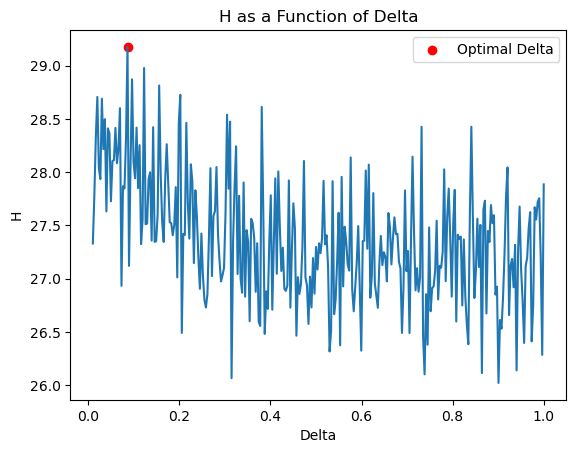

In [15]:
np.random.seed(seed_1)

delta_values = np.linspace(0.01, 1, 300)  # Range of Delta values to consider
H_values = []  # List to store the H values

for delta in delta_values:
    H = calculate_H_Delta_hoarding(K, Delta=delta)
    H_values.append(H)

max_H = max(H_values)
optimal_delta = delta_values[H_values.index(max_H)]

print('The maximum value of H is: ', max_H)
print('The optimal value of Delta is: ', optimal_delta)

# Plotting
plt.plot(delta_values, H_values)
plt.xlabel('Delta')
plt.ylabel('H')
plt.title('H as a Function of Delta')
plt.scatter(optimal_delta, max_H, color='red', label='Optimal Delta')
plt.legend()
plt.show()

The new ploicy is less effective in increasing profits than the one given in question 4. The idea was to make sure not too small adjustments were made compared to the cost, but this was not effetive. An idea for further research is to optimize with respect to the number of periods we look back at. Adjusting from 5 periods to fewer periods might improve the suggested policy. 

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [16]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

# Test global minimum
griewank([0,0])

0.0

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [17]:

def refined_global_optimizer(bound_1, bound_2, tolerance, K_bar, K):
    x_star = None  # Best solution found so far
    x_k0_list = []  # Track the effective initial guesses
    num_iterations = 0  # Counter for number of iterations

    # Step 1: Set bounds and tolerance
    bounds = [-bound_1, bound_2]
    tau = tolerance
    np.random.seed(1982) # set seed for reproducibility

    # Step 2: Choose number of warm-up iterations and maximum number of iterations
    K_warmup = K_bar
    K_max = K

    # Step 3:     
    for k in range(K_max):
        # Step 3.A: Draw random x^k uniformly within chosen bounds
        x_k = np.random.uniform(bounds[0], bounds[1], 2)

        # Step 3.B: Check if k < K_warmup
        if k < K_warmup:
            x_k0 = x_k  # Skip to step 3.E
        else:
            # Step 3.C: Calculate chi^k
            chi_k = 0.5 * 2 / (1 + np.exp((k - K_warmup) / 100))
            # Step 3.D: Set x^k0
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star

        # Step 3.E: Run optimizer with x^k0 as initial guess and x^k* as result
        result = minimize(griewank, x_k0, method='BFGS', tol=tau)
        x_k_star = result.x

        # Step 3.F: Update x*
        if x_star is None or griewank(x_k_star) < griewank(x_star):
            x_star = x_k_star

        # Step 3.G: Check if termination condition is met
        if griewank(x_star) < tau:
            break

        # Increment the iteration counter
        num_iterations += 1

        # Store x_k0 for plotting
        x_k0_list.append(x_k0)

    # Convert the list to a numpy array for plotting
    x_k0_list = np.array(x_k0_list)

    plt.figure(figsize=(12, 8))
    plt.style.use('ggplot')

    # Plotting the effective initial guesses
    plt.subplot(2, 3, 1)
    plt.scatter(x_k0_list[:, 0], x_k0_list[:, 1], c='skyblue')  
    plt.axhline(0, color='black', linewidth=0.5)  # Tilføj denne linje for X=0
    plt.axvline(0, color='black', linewidth=0.5)  # Tilføj denne linje for Y=0
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Effective Initial Guesses')

    # Plotting the histogram for x1
    plt.subplot(2, 3, 2)
    plt.hist(x_k0_list[:, 0], bins=20, color='skyblue', alpha=0.5) 
    plt.xlabel('$x_1$')
    plt.ylabel('Frequency')
    plt.title('Distribution of $x_1$')

    # Plotting the histogram for x2
    plt.subplot(2, 3, 3)
    plt.hist(x_k0_list[:, 1], bins=20, color='skyblue', alpha=0.5)  
    plt.xlabel('$x_2$')
    plt.ylabel('Frequency')
    plt.title('Distribution of $x_2$')
    plt.tight_layout()

    plt.show()

    return x_star, num_iterations

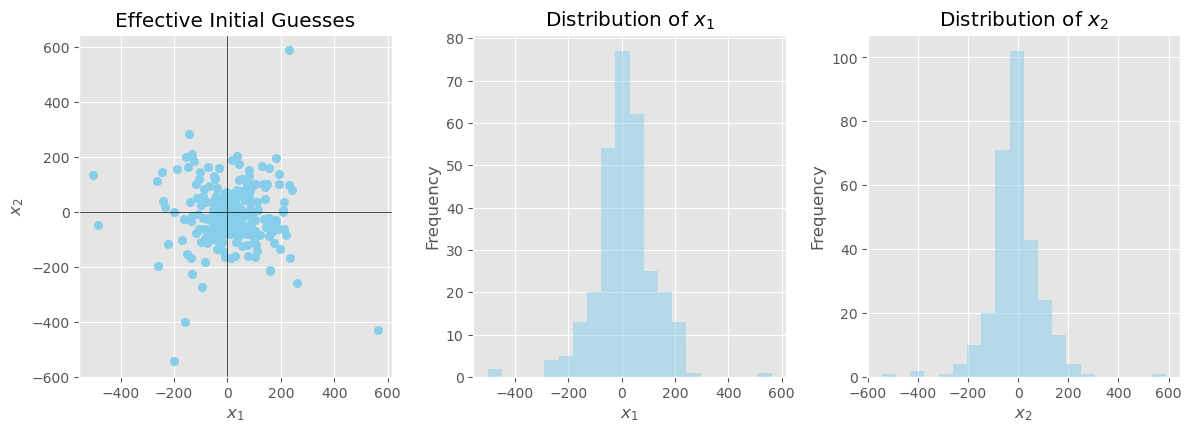

Elapsed time: 1.71 seconds
Number of Iterations: 297
Global Minimum:
x* = [-1.35505234e-08 -1.43453583e-08]
f(x*) = 1.1102230246251565e-16


In [18]:
#Start the timer
start_time = time.time()

# Run the optimizer
solution, num_iterations = refined_global_optimizer(600, 600, 0.00000001, 10, 1000)

# Calculate the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print("Number of Iterations:", num_iterations)

print("Global Minimum:")
print("x* =", solution)
print("f(x*) =", griewank(solution))

We that the algorithm takes some initial guesses that are far from the global minimum, but relatively fast it converges to a dense cloud of points in the area around the global minimum. From the histograms $x_1$ and $x_2$ we see that there is almost no tails on the diostribution of the effective initial guesses, besides a few outliers which are some of the first guesses. 

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

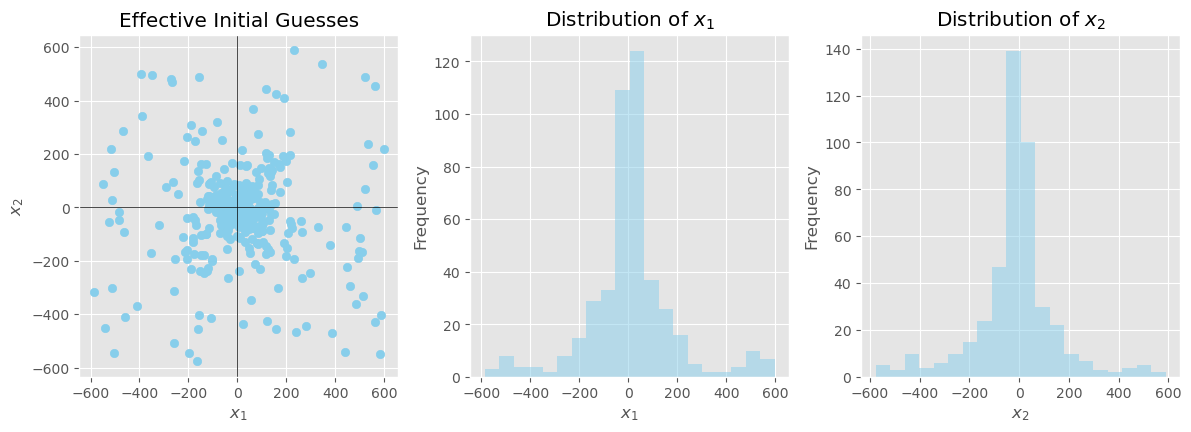

Elapsed time: 2.31 seconds
Number of Iterations: 448
Global Minimum:
x* = [-1.09591415e-08 -1.26837460e-08]
f(x*) = 1.1102230246251565e-16


In [19]:
#Start the timer
start_time = time.time()

# Run the optimizer
solution, num_iterations = refined_global_optimizer(600, 600, 0.00000001, 100, 1000)

# Calculate the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
print("Number of Iterations:", num_iterations)

print("Global Minimum:")
print("x* =", solution)
print("f(x*) =", griewank(solution))

We see that for the same seed, the convergence to the global minimum is actually slower for 100 warmup iterations compared to 10: 448 iterations when setting the warm-up iterations to 100 compared to 297 iterations when using 10 warm-up iterations. When we increase the number of warm-up iterations, the algorithm spends more initial time on exploring the search space before it starts using the refined initial guesses. This is evident from the scatter plot and the histograms of $x_1$ and $x_2$. The scatterplot with 10 warm-ups has no more than 10 values in the periphery of the search space while when using 100 warm-ups there is substantially more numbers in the periphery. When looking at the histograms of $x_1$ and $x_2$ we see that the search with 100 warm-ups has more guesses in the tails. 

The increased runtime can be attributed to the fact that the algorithm needs to evaluate then funtcion more times during warm-up iterations. Thus, the convergence time increases. This might be because the search space is relatively small. Using a larger search space might make the warm-up iterations more valuable. 

However, it is a trade-off between exploration of the function and speed. 